##Submitted by
Saurabh Mehra(23EC65R06) \\
Anshu Pal(23EC65R04)

In [5]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/D1/
  inflating: Data/D1/GT1.npy         
  inflating: Data/D1/img1.jpg        
  inflating: Data/D1/img2.jpg        
   creating: Data/D2/
  inflating: Data/D2/GT2.npy         
  inflating: Data/D2/img1.jpg        
  inflating: Data/D2/img2.jpg        
   creating: Data/D3/
  inflating: Data/D3/GT3.npy         
  inflating: Data/D3/img1.jpg        
  inflating: Data/D3/img2.jpg        


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [11]:
gt = np.load("./Data/D3/GT3.npy")

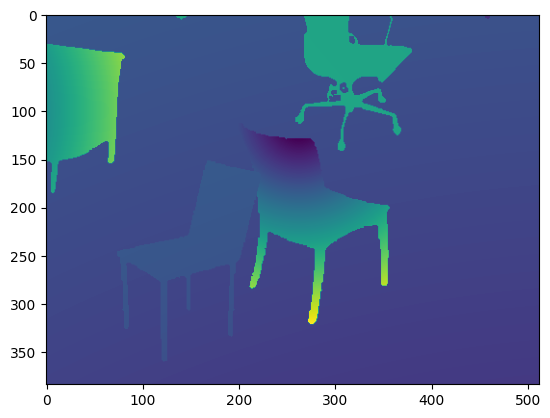

7.6324596 86.68411


In [12]:
plt.imshow(gt)
plt.show()

print(min(gt.flatten()), max(gt.flatten()))

In [13]:
def get_gray_images(filenames):
  gray_images = []
  for filename in filenames:
    img = cv.imread(filename)


    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)/255
    gray_images.append(gray_img)

  return gray_images

In [14]:
def get_block(img, block_size, cord):

  h, w = img.shape
  half_block = block_size//2
  block = np.zeros((block_size, block_size))

  for i in range(block_size):
    for j in range(block_size):
      img_x = cord[0] - half_block + i
      img_y = cord[1] - half_block + j
      if (h-1) < img_x or img_x < 0 or (w -1)< img_y or img_y < 0:
        block[i,j] = 0
      else:
        block[i,j] = img[img_x, img_y]

  return block

In [15]:

def opt_flow(filename1, filename2, win_size=3):

  k_x = np.array([[-1, 1], [-1, 1]])
  k_y = k_x.T
  k_t = np.ones((2,2))

  gray_img1, gray_img2 = get_gray_images([filename1, filename2])

  h, w = gray_img1.shape

  # I_x = [combined[:,i+1] - combined[:,i] for i in range(w-1)]
  # I_x = combined - x_shift_combined
  I_x = cv.filter2D(gray_img1, -1,  k_x)
  I_y = cv.filter2D(gray_img1, -1,  k_y)
  I_t = cv.filter2D(gray_img2, -1,  k_t) - cv.filter2D(gray_img1, -1,  k_t)



  # I_y = combined - y_shift_combined
  # print(I_x[:,-2], combined[:,-1])

  I_x = np.pad(I_x, win_size//2)
  I_y = np.pad(I_y, win_size//2)
  I_t = np.pad(I_t, win_size//2)


  u = np.zeros((h,w,2))

  for i in range(h):
    for j in range(w):
      i_x = I_x[i:i+win_size, j:j+win_size].flatten()
      i_y = I_y[i:i+win_size, j:j+win_size].flatten()
      i_t = I_t[i:i+win_size, j:j+win_size].flatten()

      b = i_t.T
      # A = np.concatenate([i_x.T, i_y.T], axis=1)
      A = np.vstack([i_x, i_y]).T
      ATA = np.matmul(A.T, A)
      if np.linalg.det(ATA) < 1e-10:
        continue

      U = np.matmul(np.linalg.pinv(A), b)
      # print(U.shape, U)
      u[i,j] = U
      # print(u)
      # break
    # break

  return u


# u = opt_flow("./Data/D2/img1.jpg", "./Data/D2/img2.jpg", win_size=15)
# plt.imshow(u, cmap='gray')
# plt.show()

# loss = np.sum((u/np.linalg.norm(u) - gt/np.linalg.norm(gt))**2)
# def print(loss)

In [16]:
def block_matching(filename1, filename2, win_size=16, search_area=7):
  gray_img1, gray_img2 = get_gray_images([filename1, filename2])

  h, w = gray_img1.shape

  gray_img1 = np.pad(gray_img1, search_area//2)
  gray_img2 = np.pad(gray_img2, win_size//2)

  U = np.zeros((h,w,2))

  for i in range(h):
    if i%10 == 0:
      print(F"complete {i} of {h}")
    for j in range(w):
      prev_block = get_block(gray_img1, search_area, (i,j))

      min_loss = float('inf')

      for m in range(-win_size//2, win_size//2 + 1):
        for n in range(-win_size//2, win_size//2 + 1):
          curr_block = get_block(gray_img2, search_area, (i+m,j+n))
          # print(i+m,i+m+search_area,j+n,j+n+search_area)

          loss = np.sum((prev_block - curr_block)**2)

          if loss < min_loss:
            min_loss = loss
            U[i, j] = [m-win_size//2, n-win_size//2]

  return U

In [17]:
# u = block_matching("./Data/D2/img1.jpg", "./Data/D2/img2.jpg", win_size=16, search_area=7)
# mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)
# plt.imshow(mag, cmap='gray')
# plt.show()

In [18]:
def three_step_search(filename1, filename2,
                      search_parameter=7, step_size=4):
    gray_img1, gray_img2 = get_gray_images([filename1, filename2])

    h, w = gray_img1.shape

    U = np.zeros((h, w, 2))

    for i in range(0, h):
        if i %25 == 0:
          print(F"Row {i} of {h}")
        for j in range(0, w):
            prev_block = get_block(gray_img1, search_parameter, (i,j))

            min_loss = float('inf')
            best_m, best_n = 0, 0

            s = step_size
            offset_x, offset_y = 0, 0

            while s >= 1:
              for m in [0,1,-1]:
                  for n in [0,1,-1]:
                      curr_block = get_block(gray_img2,
                                             search_parameter,
                                             (i- m*s + offset_x,
                                              j- n*s + offset_y))
                      # print((i- m*s + offset_x,
                      #                         i- n*s + offset_y))
                      # plt.imshow(curr_block)
                      # plt.show()
                      # break
                      loss = np.sum((prev_block - curr_block) ** 2)

                      if loss < min_loss:
                          min_loss = loss
                          best_m, best_n = m*s, n*s

              offset_x += best_m
              offset_y += best_n
              best_m, best_n = 0,0
              s = s//2
              min_loss = float('inf')

            U[i, j] = [offset_x, offset_y]

    return U

# u = three_step_search("./Data/D2/img1.jpg",
#                    "./Data/D2/img2.jpg",
#                    search_parameter=7, step_size=4)
# mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)
# plt.imshow(mag, cmap='gray')
# plt.show()

In [19]:
# plt.imshow(mag, cmap='gray')
# plt.show()

In [ ]:
def diamond_search(filename1, filename2,
                      search_parameter=7, step_size=2):
    gray_img1, gray_img2 = get_gray_images([filename1, filename2])

    h, w = gray_img1.shape

    U = np.zeros((h, w, 2))

    for i in range(0, h):
        if i %25 == 0:
          print(F"Row {i} of {h}")
        for j in range(0, w):
            prev_block = get_block(gray_img1, search_parameter, (i,j))

            min_loss = float('inf')
            prev_loss = float('inf')
            best_m, best_n = 0, 0

            s = step_size
            offset_x, offset_y = 0, 0
            total_steps = 0

            while s >= 1:
              for m in [0,1,-1]:
                  for n in [0,1,-1]:
                      if (abs(m*s) + abs(n*s)) != s:
                        continue

                      curr_block = get_block(gray_img2,
                                             search_parameter,
                                             (i- m*s + offset_x,
                                              j- n*s + offset_y))
                      # print((i- m*s + offset_x,
                      #                         i- n*s + offset_y))
                      # plt.imshow(curr_block)
                      # plt.show()
                      # break
                      print(s)
                      loss = np.sum((prev_block - curr_block) ** 2)

                      if loss < min_loss:
                          prev_loss = min_loss
                          min_loss = loss
                          best_m, best_n = m*s, n*s

              offset_x += best_m
              offset_y += best_n
              print(best_m, best_n, loss, offset_y, offset_x, prev_loss)
              if (best_m == 0 and best_n == 0) or prev_loss < loss:
                s = s//2
              # min_loss = float('inf')

            U[i, j] = [offset_x, offset_y]

    return U

u = diamond_search("./Data/D2/img1.jpg",
                   "./Data/D2/img2.jpg",
                   search_parameter=7, step_size=2)
mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)
plt.imshow(mag, cmap="gray")
plt.show()

Streaming output truncated to the last 5000 lines.
2
2
2
0 2 3.6910111495578626 513618 0 inf
2
2
2
2
0 2 3.6910111495578626 513620 0 inf
2
2
2
2
0 2 3.6910111495578626 513622 0 inf
2
2
2
2
0 2 3.6910111495578626 513624 0 inf
2
2
2
2
0 2 3.6910111495578626 513626 0 inf
2
2
2
2
0 2 3.6910111495578626 513628 0 inf
2
2
2
2
0 2 3.6910111495578626 513630 0 inf
2
2
2
2
0 2 3.6910111495578626 513632 0 inf
2
2
2
2
0 2 3.6910111495578626 513634 0 inf
2
2
2
2
0 2 3.6910111495578626 513636 0 inf
2
2
2
2
0 2 3.6910111495578626 513638 0 inf
2
2
2
2
0 2 3.6910111495578626 513640 0 inf
2
2
2
2
0 2 3.6910111495578626 513642 0 inf
2
2
2
2
0 2 3.6910111495578626 513644 0 inf
2
2
2
2
0 2 3.6910111495578626 513646 0 inf
2
2
2
2
0 2 3.6910111495578626 513648 0 inf
2
2
2
2
0 2 3.6910111495578626 513650 0 inf
2
2
2
2
0 2 3.6910111495578626 513652 0 inf
2
2
2
2
0 2 3.6910111495578626 513654 0 inf
2
2
2
2
0 2 3.6910111495578626 513656 0 inf
2
2
2
2
0 2 3.6910111495578626 513658 0 inf
2
2
2
2
0 2 3.6910111495578

Data index:0, win_size:3
0
MSE 288.9383560332981


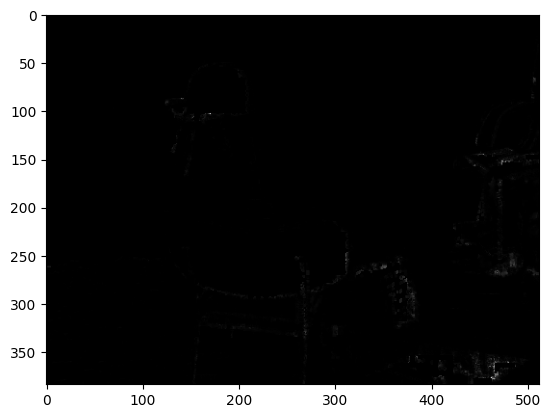

Data index:1, win_size:3
1
MSE 1057.3100408488992


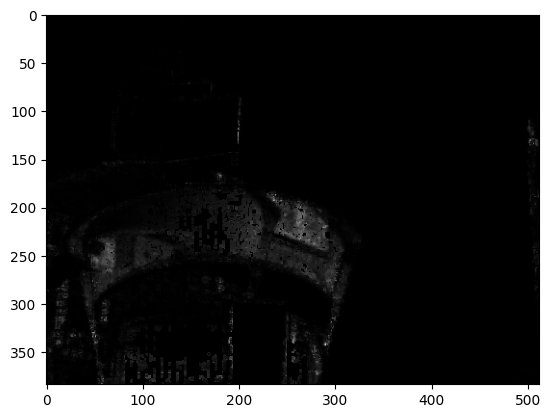

Data index:2, win_size:3
2
MSE 891.7042098413131


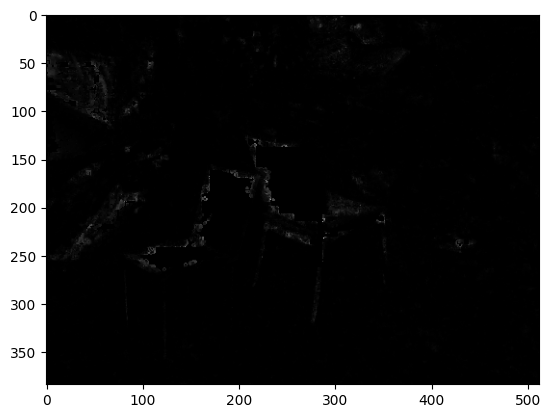

Data index:0, win_size:5
0
MSE 149.36881213666692


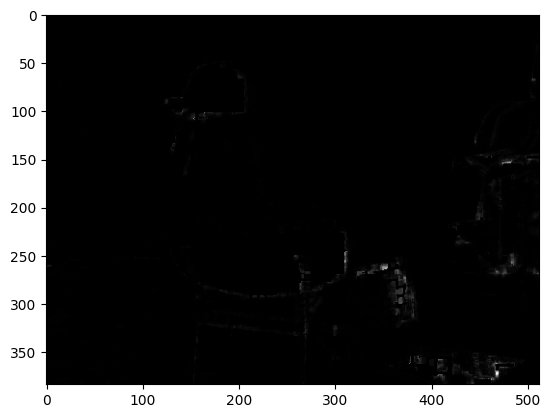

Data index:1, win_size:5
1
MSE 853.2747304756658


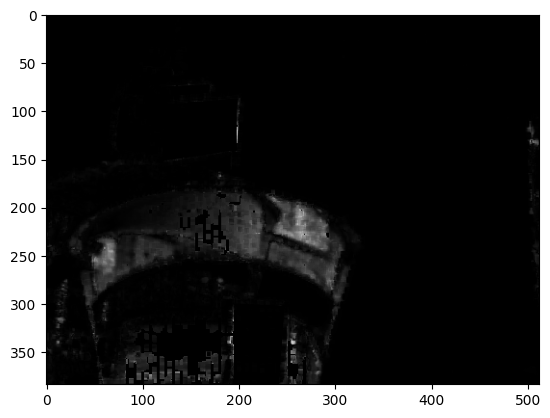

Data index:2, win_size:5
2
MSE 868.7978479899629


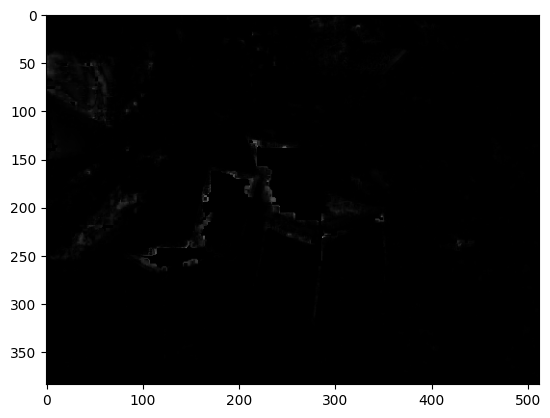

Data index:0, win_size:15
0
MSE 72.739345686909


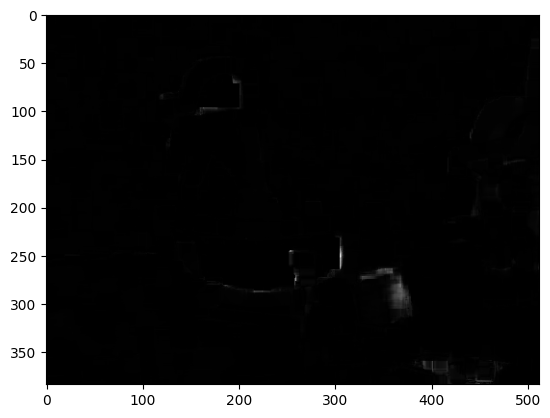

Data index:1, win_size:15
1
MSE 746.8645307860543


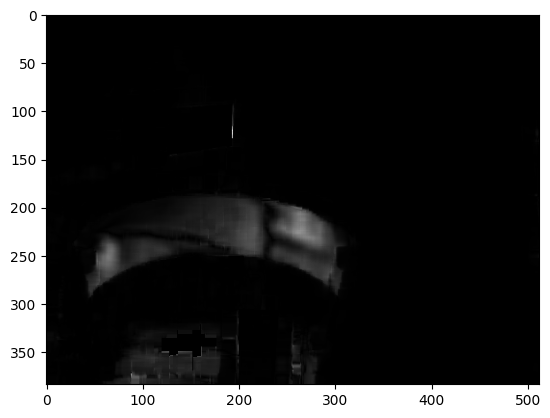

Data index:2, win_size:15
2
MSE 874.217120238547


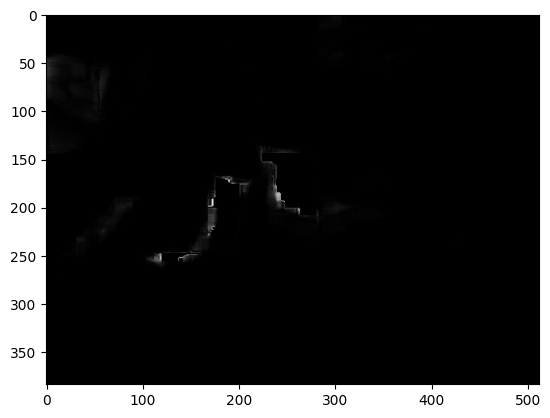

In [ ]:
# outputs
images = [[F"./Data/D{i}/img{j}.jpg" for j in range(1,3)] for i in range(1,4)]
gts = [F"./Data/D{i}/GT{i}.npy" for i in range(1,4)]
# print(images, gts)
# Q1
win_sizes = [3,5,15]

for win_size in win_sizes:
  for data_index in range(3):
    print(F"Data index:{data_index}, win_size:{win_size}")
    print(data_index)
    u = opt_flow(images[data_index][0],
                          images[data_index][1],
                          win_size = win_size)
    mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)

    gt = np.load(gts[data_index])
    h , w = mag.shape
    MSE = np.sum((mag - gt)**2)/(h*w)
    print("MSE", MSE)
    plt.imshow(mag, cmap="gray")
    plt.show()

In [ ]:
for data_index in range(1,4):
    print(F"Data index:{data_index}")
    u = three_step_search(images[data_index][0],
                              images[data_index][1],
                              search_parameter=7, step_size=4)
    mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)

    gt = np.load(gts[data_index])
    h , w = mag.shape
    loss = np.sum((mag - gt)**2)/(h*w)
    plt.imshow(mag, cmap="gray")
    plt.show()

In [ ]:
for data_index in range(1,4):
    print(F"Data index:{data_index}")
    u = diamond_search(images[data_index][0],
                              images[data_index][1],
                              search_parameter=7, step_size=2)
    mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)

    gt = np.load(gts[data_index])
    h , w = mag.shape
    loss = np.sum((mag - gt)**2)/(h*w)
    plt.imshow(mag, cmap="gray")
    plt.show()

Data index:1
Row 0 of 384


KeyboardInterrupt: 

In [ ]:
for data_index in range(1,4):
    print(F"Data index:{data_index}")
    u = block_matching(images[data_index][0],
              images[data_index][1], win_size=16, search_area=7)
    mag = np.sqrt(u[:,:,0]**2 + u[:,:,1]**2)

    gt = np.load(gts[data_index])
    h , w = mag.shape
    loss = np.sum((mag - gt)**2)/(h*w)
    plt.imshow(mag, cmap="gray")
    plt.show()

Data index:1
complete 0 of 384


KeyboardInterrupt: 